In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd

from loguru import logger

logger.enable("nviro_fetch")

In [2]:
from devices import check_and_load_devices
from env import env_global
from readings import (
    export_readings,
    import_readings,
    calculate_time_difference,
)

start_date = env_global("start_date")
end_date = env_global("end_date")
path_data = env_global("path_data")
path_readings = f"{path_data}/readings"
devices = check_and_load_devices()

In [7]:
start_date = "2025-06-17 00:00:00"
end_date = "2025-06-17 23:00:00"

## Fetch Data

In [ ]:
from nviro_fetch.auth import authenticate
from readings import get_readings


def load_data(devices, start_date=start_date, end_date=end_date):
    """
    Load data for all devices within the specified date range.
    Args:
        devices (list): List of device dictionaries containing 'devEui' and 'device_name'.
        start_date (str): Start date for fetching readings.
        end_date (str): End date for fetching readings.
    """
    token = authenticate()
    data_list = []
    for device in devices:
        device_id = device["devEui"]
        print(f"Fetching readings for {device['device_name']} ({device_id})")
        df = get_readings(token, device_id, start_date, end_date)
        params = {
        "device_name": device["device_name"],
        'df': df,
    }
        data_list.append(params)
        
    return data_list


load_data(devices=devices, start_date=start_date, end_date=end_date)

2025-06-17 16:52:15.226 | INFO     | readings:get_readings:20 - Fetching readings for device 2cf7f1c06330007c from 2025-06-17 00:00:00 to 2025-06-17 23:00:00


Fetching readings for Willow Creek Weather (2cf7f1c06330007c)


2025-06-17 16:52:15.507 | INFO     | readings:get_readings:20 - Fetching readings for device 2cf7f1c04390029c from 2025-06-17 00:00:00 to 2025-06-17 23:00:00


Fetching readings for Aquanet Light Sensor (2cf7f1c04390029c)


2025-06-17 16:52:15.811 | INFO     | readings:get_readings:20 - Fetching readings for device 2cf7f1c0645000ef from 2025-06-17 00:00:00 to 2025-06-17 23:00:00


Fetching readings for AquaNet Temp & RH (2cf7f1c0645000ef)


2025-06-17 16:52:16.122 | INFO     | readings:get_readings:20 - Fetching readings for device 2cf7f1c063300050 from 2025-06-17 00:00:00 to 2025-06-17 23:00:00


Fetching readings for AquaNet Wind (2cf7f1c063300050)


## Combine

In [ ]:
def data_processing(data_list):
    dfs_inside = [
        x["df"] for x in data_list if x["device_name"] != "Willow Creek Weather"
    ]
    df_inside = pd.concat(dfs_inside, axis=1)
    df_inside["SOLAR RADIATION"] = df_inside["LIGHT"].apply(
        lambda x: round(float(x) * 0.0079, 2)
    )
    df_inside = df_inside.drop(columns=["WIND DIRECTION", "LIGHT"])
    # ------------- Process Outside Data -------------
    df_outside = [
        data for data in data_list if data["device_name"] == "Willow Creek Weather"
    ][0]["df"]

    sensor_list = list(df_inside.columns)
    df_outside = df_outside[sensor_list]

    df_inside[sensor_list] = df_inside[sensor_list].astype(float)
    df_outside[sensor_list] = df_outside[sensor_list].astype(float)
    
    params = {
        "df_inside": df_inside,
        "df_outside": df_outside,
        "sensor_list": sensor_list,
    }
    
    return params

In [21]:
date_s_str = "2025-05-01"
date_l_str = "2025-05-01 00:00:00"
date_s = pd.to_datetime(date_s_str, format="%Y-%m-%d")
date_l = pd.to_datetime(date_l_str, format="%Y-%m-%d %H:%M:%S")
format_l = "%Y-%m-%d %H:%M:%S"

print(f"date_s: {date_s}, date_l: {date_l}")

date_s: 2025-05-01 00:00:00, date_l: 2025-05-01 00:00:00


In [22]:
type(date_s), type(date_l), type(format_l)

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp,
 str)

In [24]:
if type(date_s) == pd.Timestamp:
    print("date_s is a Timestamp")
if type(date_s) == str:
    print("date_s is string")

date_s is a Timestamp


In [9]:
dfs_inside = [
    x["df"]
    for x in data_list
    if x["device_name"] != "Willow Creek Weather"
]
df_inside = pd.concat(dfs_inside, axis=1)
df_inside["SOLAR RADIATION"] = df_inside["LIGHT"].apply(lambda x: round(float(x) * 0.0079, 2))
df_inside = df_inside.drop(columns=["WIND DIRECTION", "LIGHT"])

In [10]:
df_outside = [
    data for data in data_list if data["device_name"] == "Willow Creek Weather"
][0]["df"]

sensor_list = list(df_inside.columns)
df_outside = df_outside[sensor_list]

In [13]:
df_inside[sensor_list] = df_inside[sensor_list].astype(float)
df_outside[sensor_list] = df_outside[sensor_list].astype(float)

/var/folders/lj/7mgr94p96j5bd4lp2lrw84_w0000gn/T/ipykernel_96159/1918693339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outside[sensor_list] = df_outside[sensor_list].astype(float)


## Compare

In [15]:
sensor_list

['HUMIDITY', 'TEMPERATURE', 'WIND SPEED', 'SOLAR RADIATION']

In [18]:
sensor_name = "SOLAR RADIATION"

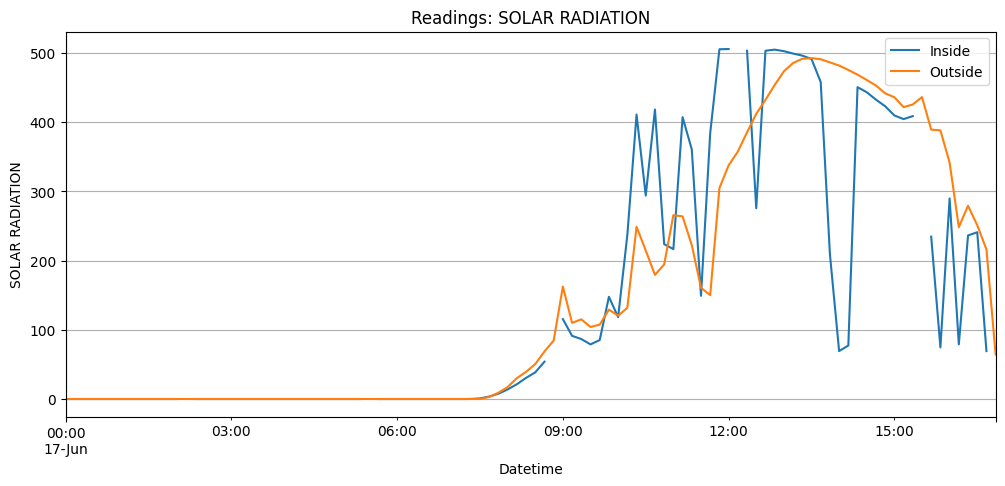

In [20]:
s1 = df_inside[sensor_name]
s2 = df_outside[sensor_name]
df = pd.concat([s1, s2], axis=1)
df.columns = ["Inside", "Outside"]
df.plot(figsize=(12, 5), title=f"Readings: {sensor_name}")
plt.xlabel("Datetime")
plt.ylabel(sensor_name)
plt.grid(True)
plt.show()